In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

import os
import calendar 

import pandas as pd
from sklearn.linear_model import Ridge

from sklearn.metrics.pairwise import rbf_kernel

In [2]:
def get_paths(base_path):
    return sorted(os.listdir(base))

def load_data(base_path, year_paths):

    if type(year_paths) == str:
        data = np.loadtxt(base_path + '/' + year_paths, usecols=[1,2,8])
    else: 
        data = [np.loadtxt(base_path + '/' + y, usecols=[1,2,8]) for y in year_paths]
        data = np.vstack(data)

    # YYYMMDD  -> DDDD
    dates = pd.to_datetime(data[:,0], format = '%Y%m%d').day_of_year
    data[:,0] = np.array(dates)

    # HHMM -> MMMM
    # Prepend 0s
    times = pd.Series(data[:,1]).astype(int).astype(str).apply(lambda x: '{0:0>4}'.format(x))
    time_deltas = times.apply(lambda x: (int(x[:2]) * 60) + int(x[-2:]))
    data[:,1] = time_deltas

    # Filter out -999 Missing Values
    valid = data[:, 2] > -999

    x = data[valid, 0:2]
    y = data[valid, 2]

    return x, y


The Yosemite Village dataset recovers daily temperatures over the 2011-216 period. We have two priors on temperature: there is seasonal variation over the course of the year, and daily variation according to the sun cycle. To capture these, the functions above convert the time feature, in format (YYYMMDD HHMM), to a day of year and minute of day representation. Below, this also used to create a test set - the entire 2016 year is witheld for this purpose. 

In [3]:
base = '../05/yosemite_village'

paths = get_paths(base)
paths_train = paths[:5]
paths_test = paths[-1] 

x_train, y_train = load_data(base, paths_train)
x_test, y_test = load_data(base, paths_test)

assert x_test.shape[1] == x_train.shape[1]

x_test.shape, x_train.shape

((105374, 2), (525480, 2))

The data across both test and train set are well-shaped, and promisingly voluminous. To investigate the new representation, we examine the plots below,

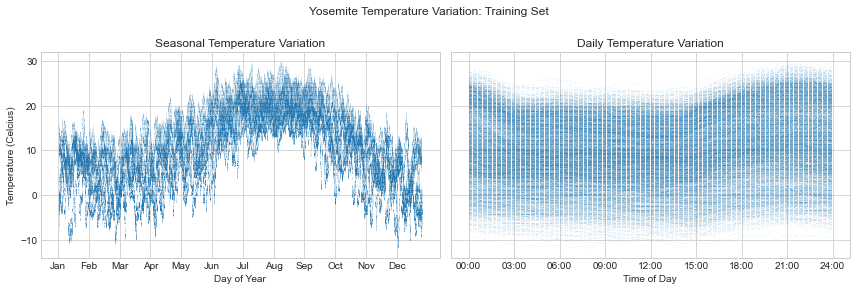

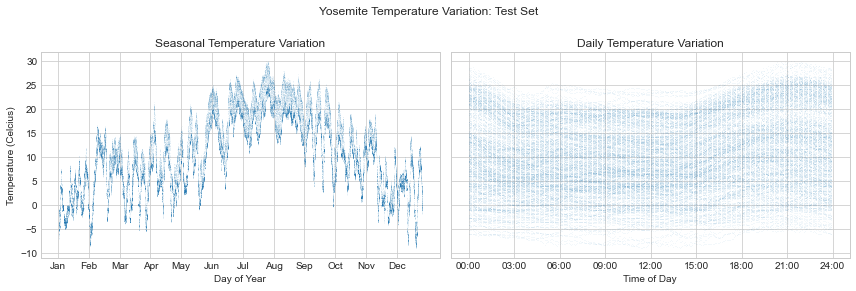

In [21]:
def temp_pairplot(x,y, lab = '', alpha = 0.01):
    fig, axs = plt.subplots(1, 2, sharey=True, figsize = (12,4), tight_layout = True,)

    for i,e in enumerate(axs):
        axs[i].plot(x[:,i], y, ',', alpha = alpha,)

    axs[0].set_ylabel("Temperature (Celcius)")
    axs[0].set_xticks(range(0, 365, 31))
    axs[0].set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)])
    axs[0].set_xlabel("Day of Year")
    axs[0].set_title("Seasonal Temperature Variation")

    axs[1].set_xticks(range(0,1441, 180))
    axs[1].set_xticklabels(['{:02d}:{:02d}'.format(*divmod(m, 60)) for m in range(0,1441, 180)])
    axs[1].set_title("Daily Temperature Variation")
    axs[1].set_xlabel("Time of Day")


    fig.suptitle(lab, y = 1)

    return fig

train = temp_pairplot(x_train, y_train, "Yosemite Temperature Variation: Training Set", alpha = 0.05)
test = temp_pairplot(x_test, y_test, "Yosemite Temperature Variation: Test Set", alpha = 0.05 )


The graphs evince two characteristics: sincere non-linearity, in both seasonal and daily variation, and high variance. Judging by eye, however, This scatter also seems to be moderatly homoscedastic - if we take a set of vertical slices along the Day of Year axis, for example, and histogram the temperatures, the variance is about the same across all slices. The latter gives a linear parameter model a good chance at making good predictions. 

In [5]:
def generate_bumps(lim, n_centers):
    # Spans the input space with bumps
    # (N, 2) will become (N, day_bumps + year_bumps)
    interval = lim // n_centers
    centers = np.array([interval*i for i in range(n_centers)]).reshape(-1,1)

    return centers

def apply_kernel(x, centers, sigma):
    # applies rbf with finicky reshape in tow
    return rbf_kernel(x.reshape(-1,1), centers, gamma = 1.0/sigma)

def join_kernelized(*args):
    # Stack back for the full extended representation
    # Column order preserved
    return np.hstack(args)


A linear parameter model is simply a linear model (ie old faithful linear regression) that fits coefficients to *features mapped in non-linear ways*. The map we use here transforms *each* feature by comparing it to centroids with some *bandwith* that span the input space. In other words, we place bumps over the input space, represent *each* feature as a bump (achieved through the kernel function), and fit the linear model. Interpreted through this candid lens, our LPM's coefficients are simply bump summers and scalers of features that are linear in a higher-dimensional space. (One point to note is that the *number* of coefficients is the sum of the number of bumps for each feature, which here is a total of 36 (12 + 24). So our featureset bloats from (N,2) to (N,36): an increase by 34 dimensions.)

However, we have to determine the number of bumps and the bandwith of each bump for *each* feature: the day of year representation and the time of day representation. If we over-bump and limit the bandwith, then we get a squiggly overfit. Conversely, if we under-bump and overdo the bandwith, we get a smooth underfit. 

In [6]:
sigma_day = 1600
sigma_year = 800

day_centers = generate_bumps(1440, 24)
year_centers = generate_bumps(365, 12)

extended_year = apply_kernel(x_train[:,0], year_centers, sigma_year)
extended_day = apply_kernel(x_train[:,1], day_centers, sigma_day)

x_train_ext = join_kernelized(extended_year, extended_day)
model = Ridge(alpha=1).fit(x_train_ext, y_train)

I am no metereologist, but I know that a day has 24 hours and a year has 12 months, which were my initial candidates for the number of centroids in the time of day and day of year feature, respectively. After some tinkering, it turns out that high bandwiths of 700 and 800 achieve a good fit, which we can evaluate by eye by plotting the marginals of each feature against the training set:

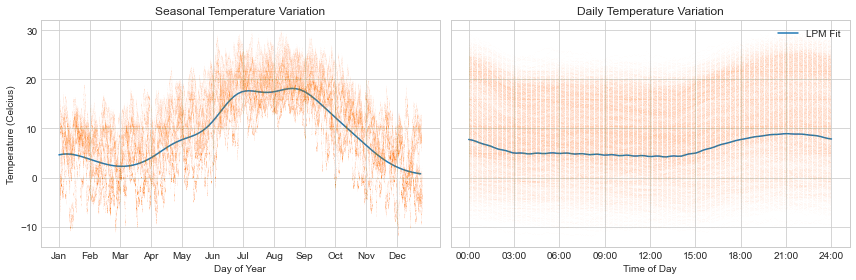

In [23]:
def marginal_plot(model, day_centers, year_centers, sigma_day, sigma_year, x, y):
    # To check contributions

    fig, axs = plt.subplots(1, 2, sharey=True, figsize = (12,4), tight_layout = True)

    # Fix time of day, vary days
    year = np.linspace(100, 100, 100).reshape(-1,1)
    day = np.linspace(0, 1440., 100).reshape(-1, 1)

    extended_year = apply_kernel(year, year_centers, sigma_year)
    extended_day = apply_kernel(day, day_centers, sigma_day)
    ext_x = join_kernelized(extended_year, extended_day)

    preds = model.predict(ext_x)

    axs[1].plot(day, preds, label = "LPM Fit")
    axs[1].plot(x[:,1], y, ',', alpha = 0.01)

    # Fix mins, vary days
    year = np.linspace(0, 365.0, 100).reshape(-1,1)
    day = np.linspace(400, 400, 100).reshape(-1, 1)
    
    extended_year = apply_kernel(year, year_centers, sigma_year)
    extended_day = apply_kernel(day, day_centers, sigma_day)
    ext_x = join_kernelized(extended_year, extended_day)

    preds = model.predict(ext_x)

    axs[0].plot(year, preds, label = "LPM Fit")
    axs[0].plot(x[:,0], y, ',', alpha = 0.01)

    axs[0].set_ylabel("Temperature (Celcius)")
    axs[0].set_xticks(range(0, 365, 31))
    axs[0].set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)])
    axs[0].set_xlabel("Day of Year")
    axs[0].set_title("Seasonal Temperature Variation")

    axs[1].set_xticks(range(0,1441, 180))
    axs[1].set_xticklabels(['{:02d}:{:02d}'.format(*divmod(m, 60)) for m in range(0,1441, 180)])
    axs[1].set_title("Daily Temperature Variation")
    axs[1].set_xlabel("Time of Day")

    plt.legend(loc = "upper right")

    return fig, axs

f, ax = marginal_plot(model, day_centers, year_centers, sigma_day, sigma_year, x_train, y_train)

These are pleasant, snug fits to the eye - what one would trace with a finger if asked to do so. The seasonal tendency of warming before summer (May - Aug), plateauing around September, before cooling until the end of the year is captured. Likewise, the moderate trend of daily variation is also captured. However, these are marginal plots (we fix the day of year to be day 100 for the Time of Day plot and fix the time of day to be 400 for the Day of Year plot), and the model jointly captures the variation better when displayed in the 3D plot below, which also evinces what it means to be 'linear in parameters':

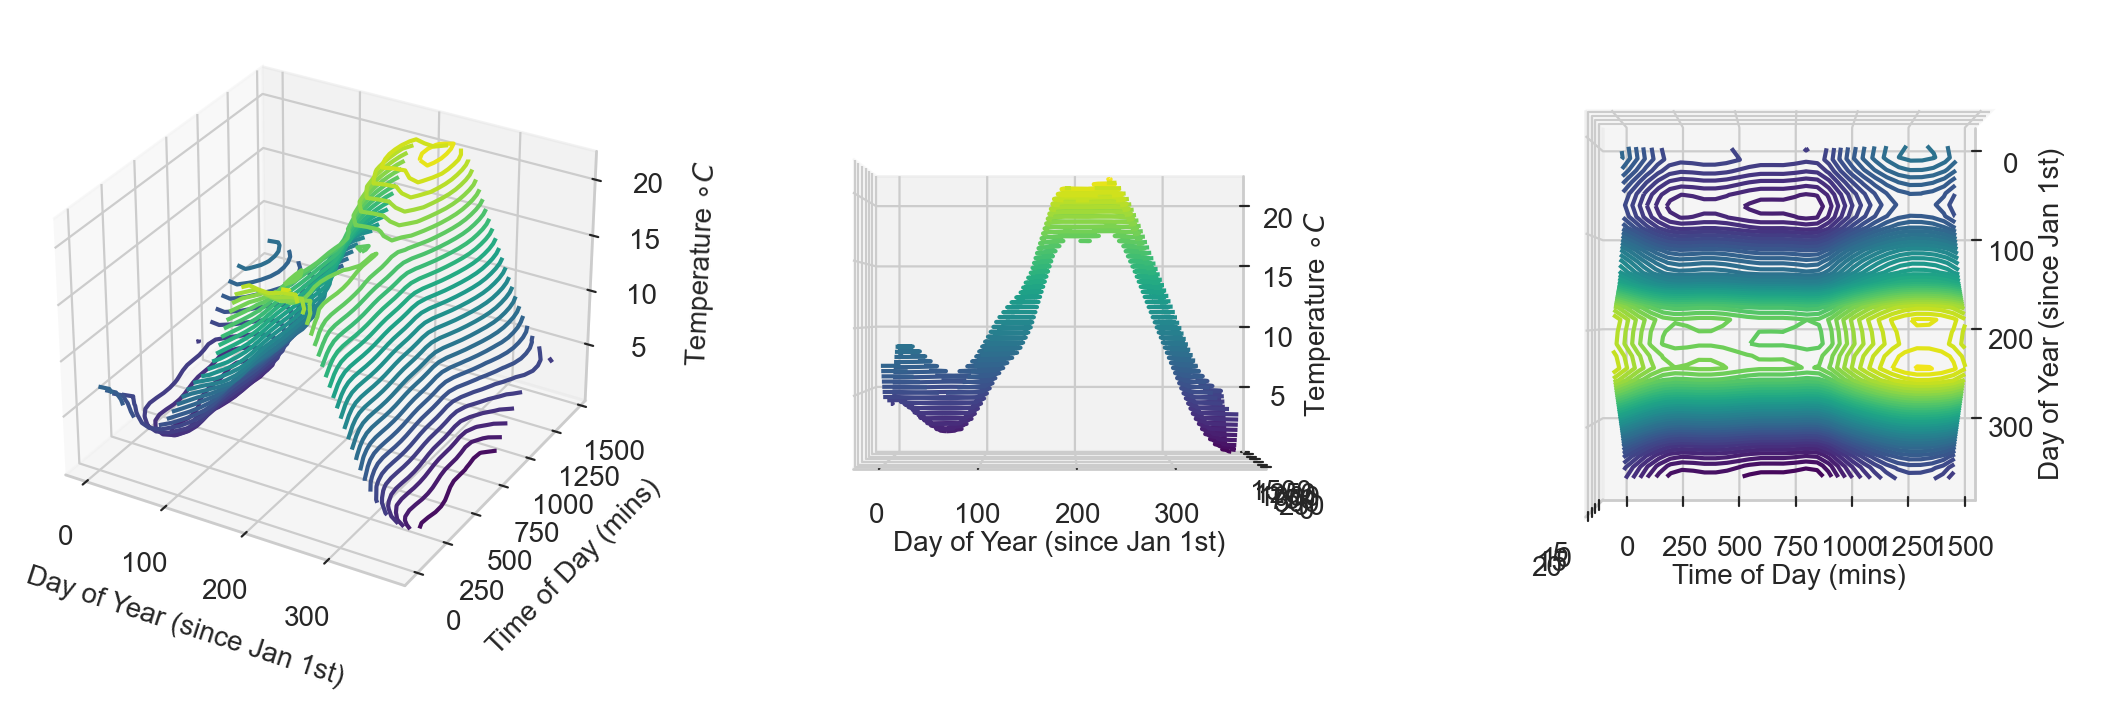

In [24]:
def return_coords(year_centers, day_centers, sigma_year, sigma_day):
    days = np.linspace(0, 365.0, 30).reshape(-1, 1)
    mins = np.linspace(0, 1440.0, 30).reshape(-1,1)

    xx, yy = np.meshgrid(days, mins)

    year_x = rbf_kernel(xx.reshape(-1,1), year_centers, gamma=1.0 / sigma_year)
    day_x =  rbf_kernel(yy.reshape(-1,1), day_centers, gamma=1.0 / sigma_day)

    Z = model.predict(np.hstack((year_x, day_x)))

    return xx, yy, Z

xx, yy, Z = return_coords(year_centers, day_centers, sigma_year, sigma_day)

fig = plt.figure(figsize=plt.figaspect(0.3), dpi = 200)

ax = fig.add_subplot(1,3,1,projection = '3d')
ax.set_ylabel("Time of Day (mins)")
ax.set_xlabel("Day of Year (since Jan 1st)")
ax.set_zlabel("Temperature ${\circ}C$")

ax.contour3D(xx,yy,Z.reshape(30,30), 30, cmap = 'viridis')

ax = fig.add_subplot(1,3,2,projection = '3d')
ax.set_xlabel("Day of Year (since Jan 1st)")
ax.set_zlabel("Temperature ${\circ}C$")

ax.contour3D(xx,yy,Z.reshape(30,30), 70, cmap = 'viridis')
ax.view_init(0, 270)

ax = fig.add_subplot(1,3,3,projection = '3d')
ax.set_ylabel("Time of Day (mins)")
ax.set_xlabel("Day of Year (since Jan 1st)")
ax.contour3D(xx,yy,Z.reshape(30,30), 50, cmap = 'viridis')
ax.view_init(90, 0)

plt.show()


Comparing the middle plot and the plot to the right, we find that the Day of Year curve is extruded along the Time of Day curve - that is, they are scaled linearly and independently by eachother. This is why we can take any marginal slice along either axis and get back the same curves as we did in the preceding plot - albeit on a different scale. Now, we can compare the performance of full and partial models by testing them on the test year of 2016 temperature readings (with the same set of bandwiths and number of centers). A parital model expands the representation of just one of the two features (for example, time of day is expanded while day of year is held constant):

In [15]:
# Over kernel-transformed 2016 x and y
extended_year = apply_kernel(x_test[:,0], year_centers, sigma_year)
extended_day = apply_kernel(x_test[:,1], day_centers, sigma_day)
x_test_ext = join_kernelized(extended_year, extended_day)

# Full model
print("Full Model:", model.score(x_test_ext, y_test))

# A model with just daily component data[:,1]
# (N,2) -> (N, (24 + 1))
extended_day = apply_kernel(x_train[:,1], day_centers, sigma_day)
ext_day_train = join_kernelized(x_train[:,0].reshape(-1,1), extended_day)

daily_model = Ridge(alpha=1).fit(ext_day_train, y_train)

extended_day_test = apply_kernel(x_test[:,1], day_centers, sigma_day)
ext_day_test = join_kernelized(x_test[:,0].reshape(-1,1), extended_day_test)

print("Model trained on expanded Time of Day:", daily_model.score(ext_day_test, y_test))
assert ext_day_test.shape[1] == 25

# A model with just yearly component data[:,0]
# (N, 0) -> (N, (12+1))

extended_year = apply_kernel(x_train[:,0], year_centers, sigma_year)
ext_year_train = join_kernelized(extended_year, x_train[:,1].reshape(-1,1))

yearly_model = Ridge(alpha=1).fit(ext_year_train, y_train)

extended_year_test = apply_kernel(x_test[:,0], year_centers, sigma_year)
ext_year_test = join_kernelized(extended_year_test, x_test[:,1].reshape(-1,1))

print("Model trained on expanded Day of Year:",yearly_model.score(ext_year_test, y_test))
assert ext_year_test.shape[1] == 13

Full Model: 0.6171786573311226
Model trained on expanded Time of Day: 0.08528260665757958
Model trained on expanded Day of Year: 0.5907844799844304


The full model has an $R^2$ of 61.6%, explaining a large portion of the variance in the 2016 temperatures (which can be witnessed viscerally in the plot below). The time of day partial model explains about 8.5%, while the day of year model explains about 59.1%. These two readouts are vastly more interpretable claims about feature importance than reading off 36 coefficients in the expanded representation: when predicting the temperature of Yosemite Village, the day of the year holds more predictive power than the time of the day. This corresponds to what Pedro told me as I was packing for Berlin:

> Andre: do I need to pack a coat? I might need a check-in bag. 


> Pedro: you won't initially, but it gets colder in December and you will need it then.

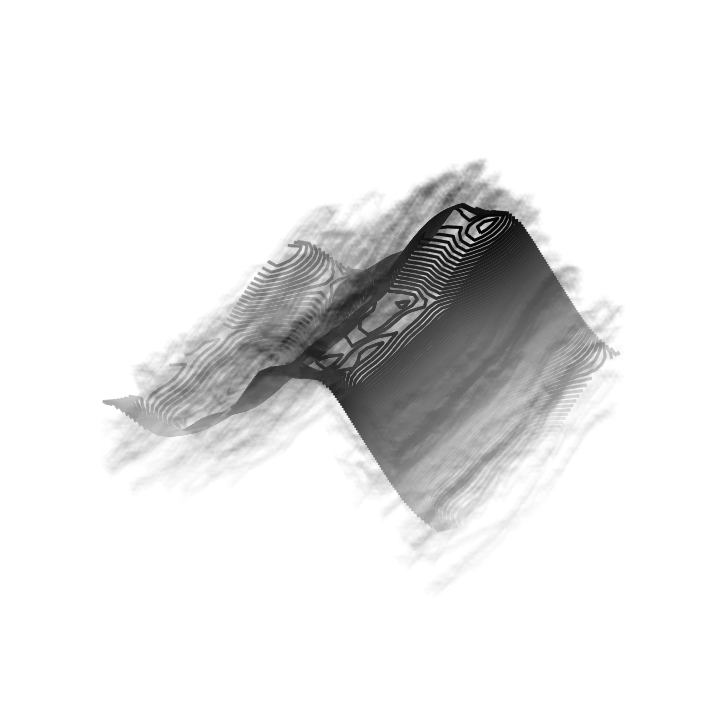

In [81]:
xx, yy, Z = return_coords(year_centers, day_centers, sigma_year, sigma_day)

fig = plt.figure(figsize=(20,20), dpi = 150)

ax = fig.add_subplot(1,3,1,projection = '3d')
ax.set_ylabel("Time of Day (mins)")
ax.set_xlabel("Day of Year (since Jan 1st)")
ax.set_zlabel("Temperature ${\circ}C$")

ax.contour3D(xx,yy,Z.reshape(30,30), 80, cmap = 'binary')
ax.scatter3D(x_test[:,0], x_test[:,1], y_test, alpha = 0.01, marker = '1', c = y_test, cmap = 'binary')
ax.set_axis_off()

plt.show()